In [55]:
import numpy as np
from matplotlib import pyplot as plt
import math
import lasio
import os
import pandas as pd
path_to_RIGIS = r'./welldata/RIGIS/'
path_to_GIS = r'./welldata/GIS_md/'
path_to_welltracks = r'./welldata/welltracks.txt'
lasFileNames = []

def getLasDataFrames(path = path_to_RIGIS):
    lasDF = []
    for file in os.listdir(path):
        if file.endswith('.las'):
            lasFileNames.append(file[:-4])
            lasDF.append(lasio.read(path+file).df())
    return lasDF

lasDataFrame = getLasDataFrames()

In [56]:
len(lasDataFrame)

72

In [57]:
def parse_welltracks():
    welltracks = []
    f = open(path_to_welltracks)
    welldata = f.read().split(';')
    for well in welldata:
        if len(well.split()) > 2:
            name = well.split()[2][:-1]
            data = well.split()[3:]
            x = [float(data[i]) for i in range(len(data)) if i % 4 == 0]
            y = [float(data[i]) for i in range(len(data)) if i % 4 == 1]
            tvdss = [float(data[i]) for i in range(len(data)) if i % 4 == 2]
            md = [float(data[i]) for i in range(len(data)) if i % 4 == 3]
            if(lasFileNames.count(name) > 0):
                welltracks.append([name, x, y ,tvdss, md]) # в таком виде хранятся
            else:
                print(name)

    return welltracks


In [58]:
from scipy.interpolate import interp1d
import math
def get_heights_list():
    welltracks = parse_welltracks()
    tvdconv = []
    for tracknum in range(len(welltracks)):
        f = interp1d(welltracks[tracknum][4], welltracks[tracknum][3])
        tvdconv.append(f)

    heights = []
    print(len(lasDataFrame))
    for k  in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        tmp_sum = 0
        for i in range(len(frame['KG_T']) - 1):
            if (frame['KG_T'].array[i + 1] >= 0):
                tmp_sum += tvdconv[k](frame['KG_T'].index[i + 1]) - tvdconv[k](frame['KG_T'].index[i])
        heights.append(tmp_sum)
    return heights
get_heights_list()

20-1
30-1
48-1
54-1
68-1
73-1
72


[25.130624479999938,
 35.88004108000018,
 27.795775679999906,
 21.800000000000068,
 35.19999999999993,
 40.299999999999955,
 30.4990808,
 42.698541400000295,
 11.999999999999886,
 31.70000000000016,
 20.690719200000103,
 41.49842736000005,
 23.09999999999991,
 24.090025479999895,
 11.299596400000269,
 0,
 17.495392559999914,
 21.397067200000038,
 11.994480901960742,
 13.491289599999845,
 25.39649980000013,
 0,
 32.096490119999544,
 27.296491832604715,
 0,
 34.500000000000114,
 24.399999999999977,
 3.7000000000000455,
 27.089828480000165,
 26.393831519999708,
 14.799999999999955,
 28.39720504000013,
 12.49417847999996,
 40.19720349999977,
 31.999509200000375,
 26.09999999999991,
 25.99109195999995,
 38.79760999999985,
 22.49968494999996,
 0,
 3.0903043999999227,
 31.9995732000001,
 35.39548859999991,
 0,
 0,
 26.690883680000184,
 27.599591499999974,
 0,
 28.29829416000007,
 21.344618600000103,
 27.599226000000385,
 25.86429329999976,
 35.17188149999993,
 39.94499770000016,
 22.596334850

In [59]:
def get_k_nas_por():
    k_nas = []
    k_por = []
    for k in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        k_nas.append([val for val in frame['KG_T']])
        for k_w in range(len(k_nas)):
            for k in range(len(k_nas[k_w])):
                if math.isnan(k_nas[k_w][k]):
                    k_nas[k_w][k] = 0
        k_por.append([val for val in frame['KP_T']])

        for k_w in range(len(k_por)):
            for k in range(len(k_por[k_w])):
                if math.isnan(k_por[k_w][k]):
                    k_por[k_w][k] = 0
    return (k_nas, k_por)
k_nas,k_por = get_k_nas_por()

In [60]:
def dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)
    
def perimeter(boundary):
    (prev_x,prev_y) = boundary[-1]
    perim = 0
    for (x,y) in boundary:
        perim += dist(x,y,prev_x,prev_y)
        prev_x, prev_y = x,y
    return perim
def getCommonLength(boundary1, boundary2):
    first_pt = -1
    second_pt = -1
    for i in range(int(boundary1.size/2 - 1)):
        for j in range(int(boundary2.size/2 - 1)):
            (x1, y1) = boundary1[i]
            (x2, y2) = boundary2[j]
            if(x1 == x2 and y1 == y2):
                if first_pt == -1:
                    first_pt = (x1,y1)
                else:
                    second_pt = (x2, y2)
                    return dist(first_pt[0],first_pt[1],second_pt[0],second_pt[1])
    return 0
    


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely import geometry
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

welltracks = parse_welltracks()
print('len(welltrack) = ', len(welltracks))
boundary = np.load("boundary.npy",'r') 

c = np.array([(track[1][0], track[2][0]) for track in welltracks])
s = geometry.Polygon(boundary)
main_area = s.area
region_polys, region_pts = voronoi_regions_from_coords(c, s)
perimeters = []
boundaries = []
new_polys = []
print('len(region_polys) = ', len(region_polys))
for i in range(len(region_polys)):
    #print(type(region_polys[i]))
    try:
        new_polys.append(region_polys[i])
        perimeters.append(perimeter(np.array(region_polys[i].boundary)))
        boundaries.append(region_polys[i].boundary)
    except Exception as e:
        perimeters.append(perimeter(np.array(list(region_polys[i])[0].boundary)))
        boundaries.append(list(region_polys[i])[0].boundary)


20-1
30-1
48-1
54-1
68-1
73-1
len(welltrack) =  72
len(region_polys) =  72


/home/evgeny/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
len(boundaries)

72

len(welltracks) =  72


/home/evgeny/.local/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/evgeny/.local/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


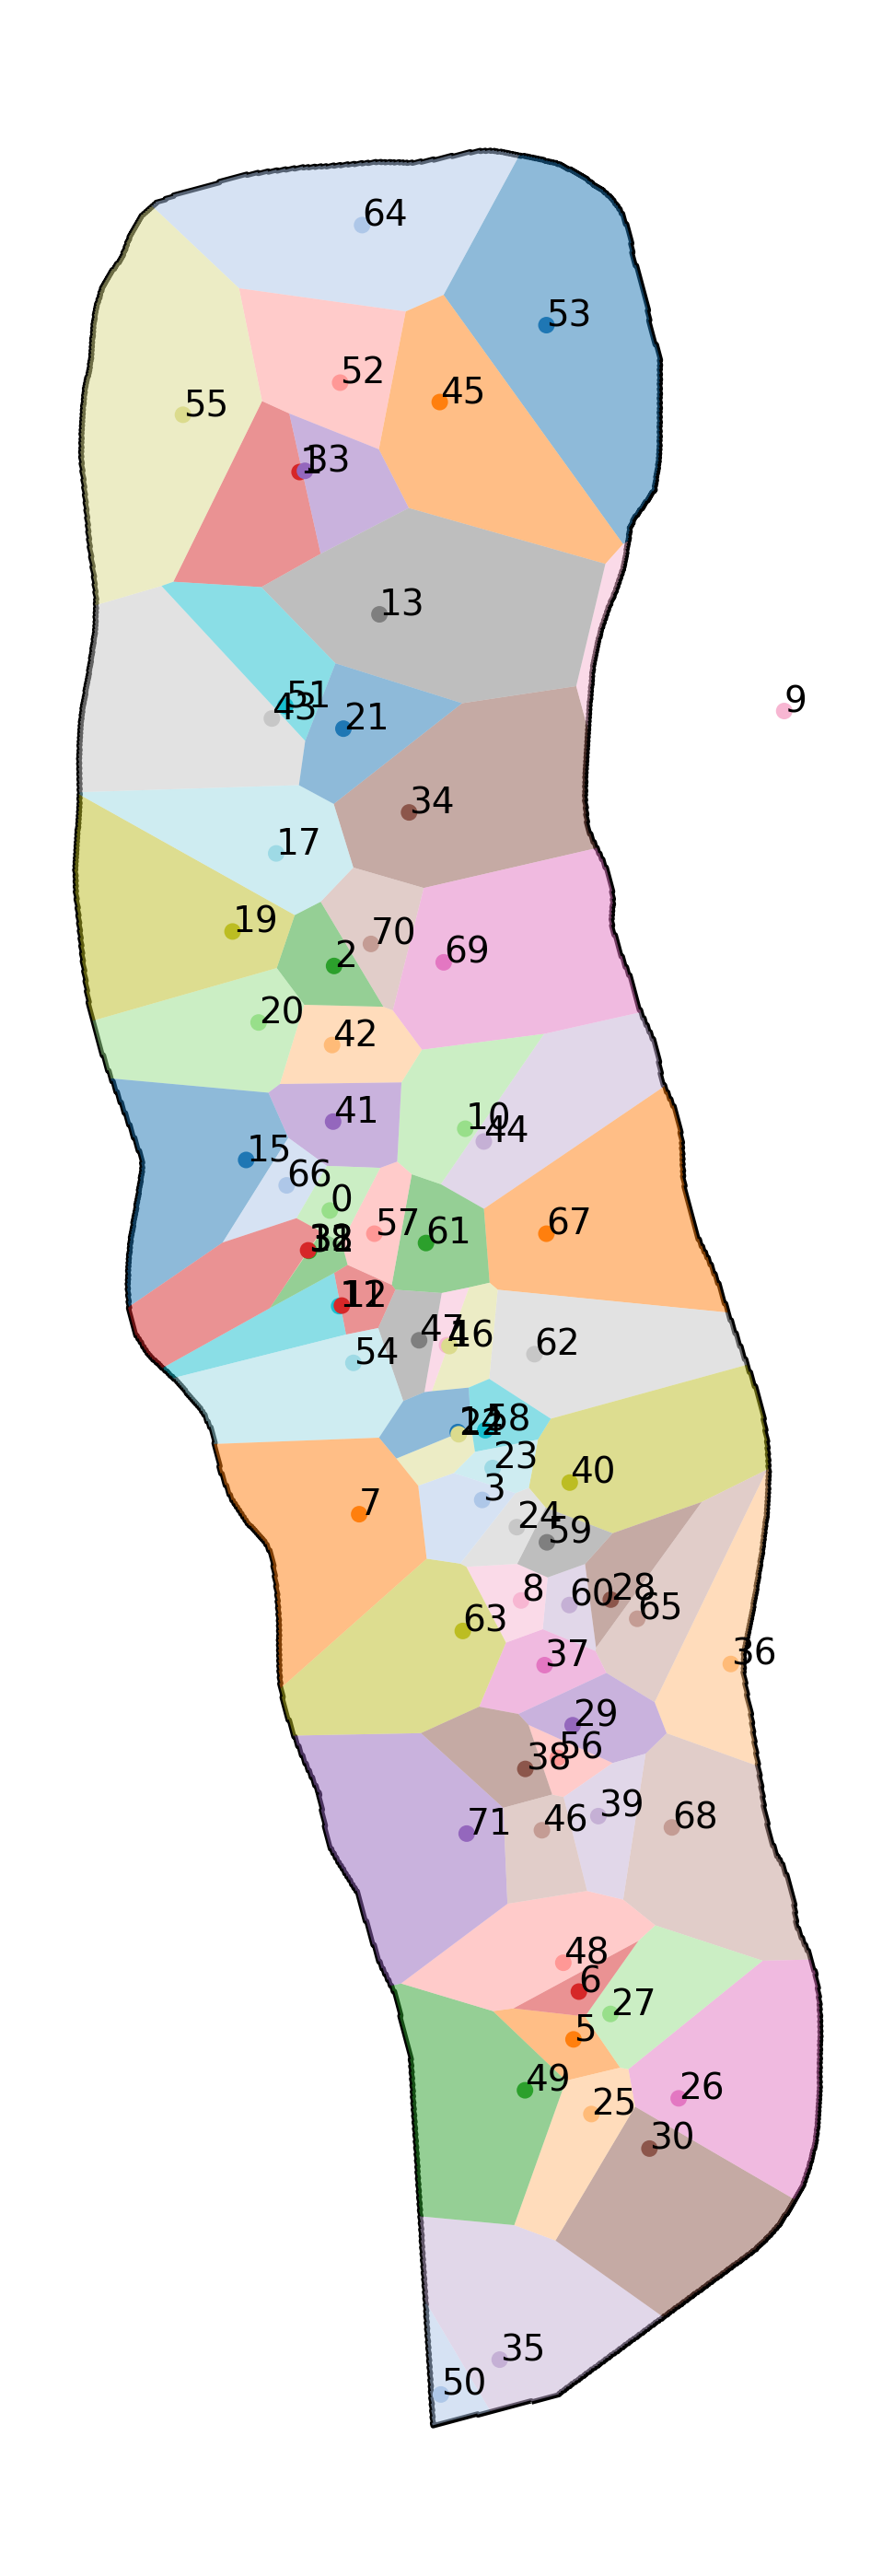

In [63]:

#print(perimeters)
fig, ax = subplot_for_map(figsize=(15, 9), dpi=400)
print("len(welltracks) = ", len(welltracks))
for i in range(len(welltracks)):
    ax.annotate(str(i), (welltracks[i][1][0], welltracks[i][2][0]), fontsize=7)
plot_voronoi_polys_with_points_in_area(ax, s, region_polys, c, region_pts)
plt.show()


In [64]:

mat_size = len(welltracks)
print('mat size is ', mat_size)
adj_mat = [np.array([-1 for i in range(mat_size)]) for j in range(mat_size)]
for i in range(mat_size - 1):
    for j in range(mat_size - 1):
        for reg1 in region_pts[i]:
            for reg2 in region_pts[j]:
                if (i == j):
                    adj_mat[reg1][reg2] = 0
                    continue
                adj_mat[reg1][reg2] = getCommonLength(np.array(boundaries[i]), np.array(boundaries[j]))
                if(adj_mat[reg1][reg2] > 0):
                    print(reg1, ' and ', reg2, ' are neibors with common length ', adj_mat[reg1][reg2])
print(adj_mat)

mat size is  72
53  and  64  are neibors with common length  6360
53  and  45  are neibors with common length  12260


/home/evgeny/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


53  and  9  are neibors with common length  200
64  and  53  are neibors with common length  6360
64  and  45  are neibors with common length  1650
64  and  52  are neibors with common length  6718
64  and  55  are neibors with common length  4804
45  and  53  are neibors with common length  12260
45  and  64  are neibors with common length  1650
45  and  52  are neibors with common length  5602
45  and  33  are neibors with common length  2630
45  and  9  are neibors with common length  1058
45  and  13  are neibors with common length  8159
42  and  2  are neibors with common length  3164
42  and  20  are neibors with common length  3307
42  and  70  are neibors with common length  400
42  and  69  are neibors with common length  1955
42  and  10  are neibors with common length  1539
42  and  41  are neibors with common length  4853
2  and  42  are neibors with common length  3164
2  and  20  are neibors with common length  1830
2  and  70  are neibors with common length  4885
2  and 

In [65]:
squares = []
from main import parse_welltracks
for i in range(len(region_polys)):
    squares.append(region_polys[i].area)

In [66]:
bg = 0.00848016
def zero_formula(S, H, kp, kg, bg = 0.00848016, ft = 1, fp = 1):
    return S*H*kp*kg/bg


In [67]:

mean_k_nas = [sum(k)/len(k) for k in k_nas if len(k) > 0]
mean_k_por = [sum(k)/len(k) for k in k_por if len(k) > 0]
heights = get_heights_list()
print(heights)
print('mean k nas',mean_k_nas[0])
print('mean k por',mean_k_por[0])
print(k_nas[0], k_por[0])

72
[25.130624479999938, 35.88004108000018, 27.795775679999906, 21.800000000000068, 35.19999999999993, 40.299999999999955, 30.4990808, 42.698541400000295, 11.999999999999886, 31.70000000000016, 20.690719200000103, 41.49842736000005, 23.09999999999991, 24.090025479999895, 11.299596400000269, 0, 17.495392559999914, 21.397067200000038, 11.999999999999886, 13.591869410256322, 25.154023750000192, 0, 32.09999999999991, 27.29590500000006, 0, 34.48551523999993, 24.399999999999977, 3.7000000000000455, 27.100000000000023, 26.399999999999864, 14.792895520000116, 28.3968676799999, 12.5, 40.196461600000134, 31.99016499999982, 26.09829259999981, 25.99995783999998, 38.799999999999955, 22.49229216000026, 0, 3.0999886999998125, 31.99061487999984, 35.299358400000074, 0, 0, 26.610106400000177, 25.25229369999977, 0, 28.290335360000086, 21.39962960000014, 27.47094096000012, 25.735108899999886, 35.1975988800001, 39.88842999999997, 22.59899109999992, 23.569486899999788, 27.57671769999979, 24.074114300000133, 

zero_formula =  94618816220.9043
len data =  72
[12, 5, 6, 29, 12, 8]


/home/evgeny/study/workshop_2022/vis_rigis_data.py:46: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout();


hist
e =  22.697513077143622
d =  139.25550206430734
integral =  0.9320710528684374


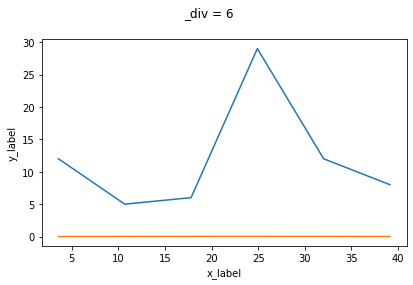

k_por med =  0.1473671951219512
k_nas med =  0.18933485365853658


In [68]:
from vis_rigis_data import visualize_data
print("zero_formula = ", zero_formula(main_area, sum(heights)/len(heights), sum(mean_k_por)/len(mean_k_por), sum(mean_k_nas)/len(mean_k_nas)))
visualize_data(heights, 6)
print("k_por med = ", mean_k_por[0])
print("k_nas med = ", mean_k_nas[0])
#plt.plot(,[])

In [69]:
len([np.mean(x) for x in k_nas])

72

In [70]:
from get_value import get_value

print(len(mean_k_nas), len(mean_k_por), len(heights), len(squares), len(adj_mat), len(perimeters))

v1 = get_value(mean_k_nas, mean_k_por, heights, squares, adj_mat, perimeters)
sum(v1)/bg

72 72 72 72 72 72


58780269993.68597

In [71]:
from get_value import get_value2

v2 = get_value2(k_nas, k_por, [[h] for h in heights], squares, adj_mat, perimeters)


TypeError: can't multiply sequence by non-int of type 'float'